# Do MO fit

0. run FDM with MO = 1.0 (do_MO_fit=.true.)
1. extract 550/830 densities from core profiles (process_firn_cores.ipynb)
2. extract locations of cores & dates
3. extract 550/830 densities from model output at correct date
4. do MO fit

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import glob
import xarray as xr
from datetime import datetime

from mo_fit_functions import *

## 2. Load the core list and match each core with an FDM point

In [3]:
#import cores
cores_df = pd.read_csv("../data/processed/MERGED_CORE_LIST_greenland_2025.csv")

# import fdm reference list
path_to_fdm_locations = "/perm/nld4814/code/IMAU-FDM/reference/FGRN055/"
pointlist_df = pd.read_csv(path_to_fdm_locations+'IN_ll_FGRN055.txt',names=["longitude","latitude","rlat","rlon"],usecols=[0,1,5,6])

In [4]:
# match core locations with FDM points

# extracts FDM points nearest to cores

save_pointlist = False

core_locations = cores_df[['latitude','longitude']].to_numpy()

df = pointlist_df

xs = []; distances = []  # distance between the pair of points
for point in core_locations:

    assert len(point) == 2, "``points`` should be a tuple or list of tuples (lat, lon)"

    p_lat, p_lon = point
    # Find absolute difference between requested point and the grid coordinates.
    abslat = np.abs(df.latitude - p_lat)
    abslon = np.abs(df.longitude - p_lon)

    # Create grid of the maximum values of the two absolute grids
    c = np.maximum(abslon, abslat)

    # Find location where lat/lon minimum absolute value intersects
    x = np.where(c == np.min(c))[0][0]
    xs.append(x)

    # Matched Grid lat/lon
    g_lat = df.iloc[x,:].latitude
    g_lon = df.iloc[x,:].longitude

    R = 6373.0  # approximate radius of earth in km

    lat1 = np.deg2rad(p_lat); lon1 = np.deg2rad(p_lon)
    lat2 = np.deg2rad(g_lat); lon2 = np.deg2rad(g_lon)
    dlon = lon2 - lon1; dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    distances.append(distance)

#pointlist_df.loc[xs].plot.scatter(x='longitude', y='latitude', title='FDM points nearest to cores', xlabel='Longitude', ylabel='Latitude',figsize=(4,5))

if save_pointlist:
    output_path = "/home/nld4814/perm/cores/pointlist_from_cores_2025.csv"
    pointlist_near_cores = pointlist_df.loc[xs].index.values
    np.savetxt(output_path, pointlist_near_cores, fmt='%d')

merged_df = cores_df.copy(deep=True)
merged_df["FDM_point_index"] = pointlist_df.loc[xs].index.values
merged_df["FDM_latitude"] = pointlist_df.loc[xs].latitude.values
merged_df["FDM_longitude"] = pointlist_df.loc[xs].longitude.values
merged_df["FDM_rlat"] = pointlist_df.loc[xs].rlat.values
merged_df["FDM_rlon"] = pointlist_df.loc[xs].rlon.values
#merged_df = merged_df.to_xarray()

## 3. load 2d data from FDM model output for each point, extract the data for that date, interpolate to 550 and 830

In [5]:
project_name = "MO_fit_cores_dpy365_25"
project_dir = f"/home/nld4814/scratch/{project_name}/"

model_settings = read_model_settings(project_dir)

file_list = [f for f in glob.glob(project_dir + "output/*" + "2D_" + "*.nc")]

path_len = len(f"{project_dir}/output/FGRN055_era055_2D")

Point False not found in /home/nld4814/scratch/MO_fit_cores_dpy365_25/ms_files/. Using the first model settings file in the directory.


In [10]:
data_df = xr.open_dataset(file_list[0])

In [20]:
data_df["point_index"] = int(file_list[0][path_len:-3]) # add fdm index to imported dataset

# find core(s) closest to this fdm point
core_match = merged_df[merged_df["FDM_point_index"] == data_df.point_index.values]

# get year
core_date= datetime(core_match.year.values[0],12,31) #end of year

ndays_timestep = 30

# add timestamp as coordinate & dimension
date_list = create_datetime(datetime(1939,9,1), datetime(2023,12,31), ndays_timestep, resample_t=None)
date_list = date_list[1:]

#replace indexed coordinates with timeseries

data_df = data_df.assign_coords(time=("ind_t",date_list)) #creates time as the coordinatedf = df.swap_dims({"ind_t":"time"}) #swaps time as the dimension from ind_t
data_df = data_df.swap_dims({"ind_t":"time"}) #swaps time as the dimension from ind_t

In [ ]:
data_df_sel = data_df.sel(time=core_date, method="nearest")


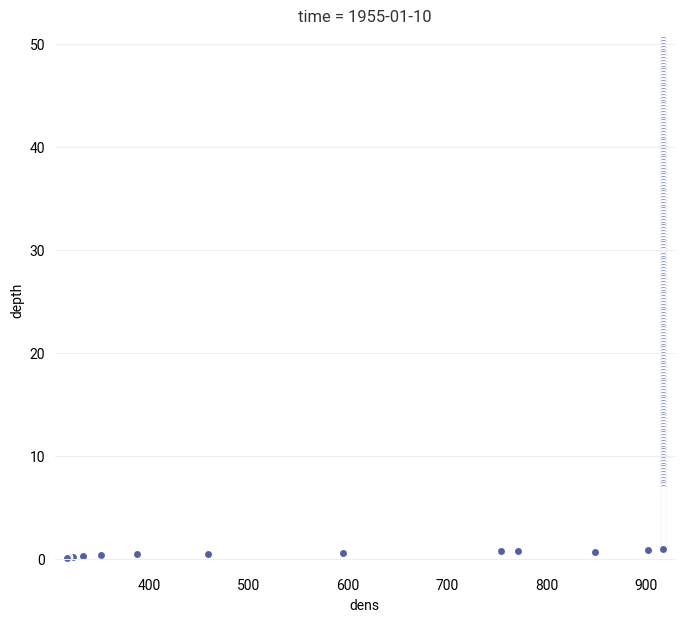

In [ ]:
fi
data_df_sel.plot.scatter(y="depth",x="dens")
core_match.plot

In [29]:
data_df_sel.depth.values

array([50.37637, 50.22637, 50.07637, ...,      nan,      nan,      nan],
      dtype=float32)